In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/ml-projects/image-colorization-cnn"

/content/drive/MyDrive/ml-projects/image-colorization-cnn


In [4]:
#import the required libraries

from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import numpy as np
import tensorflow as tf
import os

# EDA

In [5]:
#check folder structure of the dataset

for dirpath, dirname, filename in os.walk("./data"):
    print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'")

There are 2 directories and 0 images in './data'
There are 0 directories and 5 images in './data/test'
There are 1 directories and 0 images in './data/train'
There are 0 directories and 7129 images in './data/train/color'


In [6]:
# Helper functions used in this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(data_dir:str, test:bool=False):
    """This function is to help display two (2) random images in the train directory and optionally one (1) image in the test directory

    Args:
        data_dir (path): Path to the data directory
        test (bool, optional): If you wish to see an image in the test directory. Defaults to False.
    """

    #Get a random image path
    random_image = random.sample(os.listdir(data_dir), 2) #returns a list of two items(images)

    # Read in the images and plot it
    img_1 = mpimg.imread(data_dir + "/" + random_image[0])
    img_2 = mpimg.imread(data_dir + "/" + random_image[1])

    plt.figure(figsize=(13, 13))
    plt.subplot(1, 3, 1)
    plt.imshow(img_1)
    plt.title("Image[1]")
    plt.axis("off");
    print(f"Image[1] shape: {img_1.shape}")

    plt.subplot(1, 3, 2)
    plt.imshow(img_2)
    plt.title("Image[2]")
    plt.axis("off");
    print(f"Image[2] shape: {img_2.shape}")

    # if you also want to see an image from the test directory
    if test:
        random_image_test = random.sample(os.listdir("./data/test"), 1)
        img_3 = mpimg.imread("./data/test/" + random_image_test[0])
        plt.subplot(1, 3, 3)
        plt.imshow(img_3, cmap="gray")
        plt.title("Image[3]")
        plt.axis("off");
        print(f"Image[3] shape: {img_3.shape}")



def display_pred(test_dir:str, pred_dir:str, save:bool=False, save_path=None):
    """This function is to help visualize the predicted (colorized grayscale) images. It plots the original image and colorize form side by side

    Args:
        test_dir (path): path to the test images directory
        pred_dir (path): path to the predicted images
        save (bool, optional): prompt to save the image. Defaults to False.
        save_path (path, optional): dir to save the image to. Defaults to None.
    """
    n = 5

    test_images = os.listdir(test_dir)
    pred_images = os.listdir(pred_dir)

    plt.figure(figsize=(9,4))

    for i, (test_img, pred_img) in enumerate(zip(test_images, pred_images)):
        # Load test image
        test_img_path = os.path.join(test_dir, test_img)
        test = mpimg.imread(test_img_path)

        # Load predicted image
        pred_img_path = os.path.join(pred_dir, pred_img)
        pred = mpimg.imread(pred_img_path)

        # Plot test image
        plt.subplot(2, n, i + 1)
        plt.imshow(test, cmap="gray")
        plt.axis("off")
        plt.title(f"Test[{i + 1}]")

        # Plot predicted image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(pred)
        plt.axis("off")
        plt.title(f"Prediction[{i + 1}]")

        # Save the plot if save=True and save_path is provided
    if save and save_path:
        plt.savefig(save_path)



Image[1] shape: (150, 150, 3)
Image[2] shape: (150, 150, 3)
Image[3] shape: (150, 150)


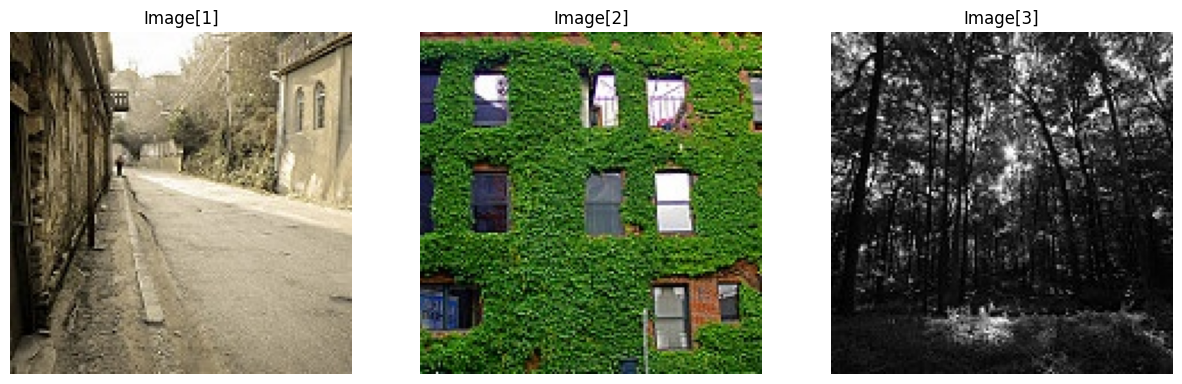

In [7]:
view_random_images("./data/train/color", test=True)

# Data Preparation

In [8]:
train_dir = "./data/train/" 


IMG_SIZE = (224, 224)
BATCH_SIZE = 1000

train_datagen = ImageDataGenerator(rescale=1./255) #rescale the images to be between 0 and 1

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,
                                               target_size=IMG_SIZE,
                                               class_mode=None)


Found 7129 images belonging to 1 classes.


In [9]:
images = next(train_data)
images.shape, len(train_data)

((1000, 224, 224, 3), 8)

In [10]:
# Convert the images from the RGB color space to the LAB color space, store the L channel in X and the A (red-green channel) and B (blue-yellow) channel in Y

X = []
Y = []

for img in train_data[0]: # over 7000 images in the train dir but training will be done with 1000 images
  try:
      lab = rgb2lab(img)
      X.append(lab[..., 0])
      Y.append(lab[..., 1:] / 128) # A and B values range from -127 to 128, divide by 128 to normalise (restrict values to between -1 and 1).
  except:
     print("Error, Recheck!")


X = np.array(X)
Y = np.array(Y)

X = X.reshape(X.shape+(1,)) #reshape the X array to correspond to the shape of the Y array
print(X.shape)
print(Y.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)


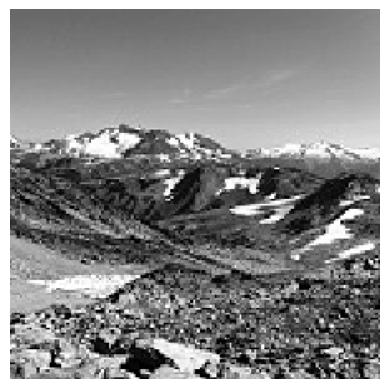

In [12]:
plt.imshow(X[7], cmap="gray")
plt.axis("off");

# Model Building 

In [13]:
# Replacing the encoder part of the autoencoder with VGG16 feature extractor layers"

from tensorflow.keras.applications.vgg16 import VGG16

vggmodel = VGG16()
encoder = Sequential()

for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      encoder.add(layer)

for layer in encoder.layers: 
  layer.trainable=False

encoder.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                      

In [18]:
# VGG16 is expecting an image with 3 channels but the L (X) layer has 2 channels, so we reshape each image by first converting to rgb, 
# and then extract features from them

from tqdm.notebook import tqdm

vggfeatures = []

for i, sample in tqdm(enumerate(X), leave=True, total=len(X)):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = encoder.predict(sample, verbose=0)
  prediction = prediction.reshape((7,7,512)) 
  vggfeatures.append(prediction)

vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 7, 7, 512)


In [84]:
# Create decoder layer for image reconstruction

decoder = Sequential()

decoder.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
decoder.add(Conv2D(128, (3,3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(64, (3,3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(32, (3,3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(16, (3,3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_5 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_6 (UpSamplin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)       

In [85]:
# create modelcheckpoint callback to resume training incase training is interrupted

from tensorflow.keras.callbacks import ModelCheckpoint

def checkpoint(folder_dir="./Checkpoint/WeightOnly.ckpt"):
    print(f"Saving Model weights only to {folder_dir}")

    checkpt = ModelCheckpoint(
        folder_dir,
        save_weights_only=True
    )

    return checkpt


In [87]:
# compile and train model

decoder.compile(optimizer="Adam", loss="mse" , metrics=["accuracy"])
decoder.fit(vggfeatures, Y, verbose=1, epochs=2000, batch_size=16, callbacks=[checkpoint()])

Saving Model weights only to ./Checkpoint/WeightOnly.ckpt
Epoch 1/2000
63/63 [==============================] - 3s 18ms/step - loss: 0.0430 - accuracy: 0.5835
Epoch 2/2000
63/63 [==============================] - 1s 19ms/step - loss: 0.0098 - accuracy: 0.6739
Epoch 3/2000
63/63 [==============================] - 1s 19ms/step - loss: 0.0087 - accuracy: 0.7053
Epoch 4/2000
63/63 [==============================] - 1s 20ms/step - loss: 0.0080 - accuracy: 0.7178
Epoch 5/2000
63/63 [==============================] - 1s 17ms/step - loss: 0.0073 - accuracy: 0.7268
Epoch 6/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.0069 - accuracy: 0.7383
Epoch 7/2000
63/63 [==============================] - 1s 15ms/step - loss: 0.0065 - accuracy: 0.7408
Epoch 8/2000
63/63 [==============================] - 1s 15ms/step - loss: 0.0061 - accuracy: 0.7517
Epoch 9/2000
63/63 [==============================] - 1s 14ms/step - loss: 0.0058 - accuracy: 0.7556
Epoch 10/2000
63/63 [============

In [88]:
#saved trained model
MODEL_DIR = "./results/model/autoencoder_colorize2000.model"

decoder.save(MODEL_DIR)

In [89]:
#reloading saved model.
autoencoder = tf.keras.models.load_model(MODEL_DIR,
                                   custom_objects=None,
                                   compile=True)


In [ ]:
#checkout the test images
test_dir = "./data/test/"
images = os.listdir(test_dir)
images

In [110]:
#predicting using saved model
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

#loop over the test images, predict and save the prediction
for x, img in tqdm(enumerate(images)):
    test = img_to_array(load_img(test_dir + img))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    vggpred = encoder.predict(L, verbose=0)
    ab = autoencoder.predict(vggpred, verbose=0)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    cur = lab2rgb(cur)
    cur *= 255
    cur = cur.astype(np.uint8)
    imsave("./results/prediction/" + str(x) + ".jpg", cur)

0it [00:00, ?it/s]

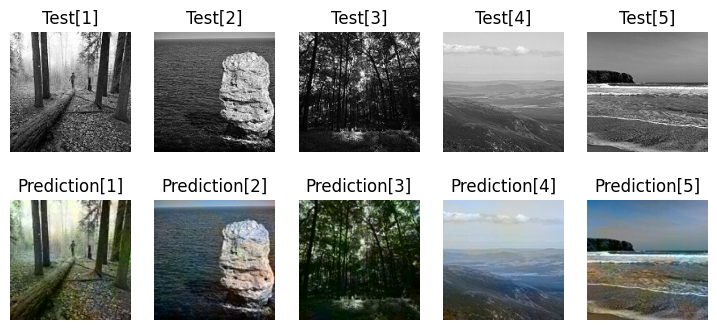

In [169]:
#display prediction
display_pred("./data/test", "./results/prediction")